# Various Encoders

In [42]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix

from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline as imbPipeline

from category_encoders import TargetEncoder, LeaveOneOutEncoder, HashingEncoder, JamesSteinEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [3]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [4]:
#Create a dictionary and helper function to track model scores.
score_dict = {}
def print_scores():
    for key in score_dict.keys():
        print(f'{key},\t f1_micro_score: {round(score_dict[key][0],4)},\t Run time: {round(score_dict[key][1],0)}')

### Divide Columns and drop unimportant features

In [5]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [6]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

### target_encoded:  Re-create the best LightGBM model (using Target Encoding on Geo columns)

From the scikit-learn website, target econding means that "features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data."

In [8]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', target_pipe, geo_cols)
])

In [9]:
target_encoded = imbPipeline([
    ('transformer', transformer),
    ('lightgbm', LGBMClassifier(objective='multiclass',
                                learning_rate=.1,
                                min_data_in_leaf=100,
                                num_iterations=200,
                                num_leaves=200,
                                n_jobs=-1, 
                                random_state=42))
])

In [10]:
start = time.time()
f1_micro_target_encoded = cross_val_score(target_encoded, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_target_encoded = end-start

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Run time: 49.76285099983215


In [11]:
f1_micro_target_encoded = f1_micro_target_encoded.mean()
f1_micro_target_encoded

0.7399232540291635

In [12]:
score_dict['target_encoded'] = [f1_micro_target_encoded, run_time_target_encoded]
print_scores()

target_encoded,	 f1_micro_score: 0.7399,	 Run time: 50.0


### leaveoneout_ecoded:  Use Leave One Out Encoding on the Geo Columns

This is very similar to target encoding but excludes the current row’s target when calculating the mean target for a level to reduce the effect of outliers.

In [14]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
leaveoneout_pipe = imbPipeline([('loo', LeaveOneOutEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', leaveoneout_pipe, geo_cols)
])

In [15]:
leaveoneout_encoded = imbPipeline([
    ('transformer', transformer),
    ('lightgbm', LGBMClassifier(objective='multiclass',
                                learning_rate=.1,
                                min_data_in_leaf=100,
                                num_iterations=200,
                                num_leaves=200,
                                n_jobs=-1, 
                                random_state=42))
])

In [16]:
start = time.time()
f1_micro_leaveoneout_encoded = cross_val_score(leaveoneout_encoded, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_leaveoneout_encoded = end-start

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Run time: 52.92627310752869


In [17]:
f1_micro_leaveoneout_encoded = f1_micro_leaveoneout_encoded.mean()
f1_micro_leaveoneout_encoded

0.6375543617293425

In [19]:
score_dict['leaveoneout_encoded'] = [f1_micro_leaveoneout_encoded, run_time_leaveoneout_encoded]
print_scores()

target_encoded,	 f1_micro_score: 0.7399,	 Run time: 50.0
leaveoneout_encoded,	 f1_micro_score: 0.6376,	 Run time: 53.0


### hashing_encoder:  Use Hashing to encode the geo columns

In [21]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
hashing_pipe = imbPipeline([('hashing', HashingEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', hashing_pipe, geo_cols)
])

In [22]:
hashing_encoded = imbPipeline([
    ('transformer', transformer),
    ('lightgbm', LGBMClassifier(objective='multiclass',
                                learning_rate=.1,
                                min_data_in_leaf=100,
                                num_iterations=200,
                                num_leaves=200,
                                n_jobs=-1, 
                                random_state=42))
])

In [24]:
start = time.time()
f1_micro_hashing_encoded = cross_val_score(hashing_encoded, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_hashing_encoded = end-start

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Run time: 390.5177059173584


In [25]:
f1_micro_hashing_encoded = f1_micro_hashing_encoded.mean()
f1_micro_hashing_encoded

0.6662522384241494

In [26]:
score_dict['hashing_encoded'] = [f1_micro_hashing_encoded, run_time_hashing_encoded]
print_scores()

target_encoded,	 f1_micro_score: 0.7399,	 Run time: 50.0
leaveoneout_encoded,	 f1_micro_score: 0.6376,	 Run time: 53.0
hashing_encoded,	 f1_micro_score: 0.6663,	 Run time: 391.0


### js_encoded:  Use James Stein Encoder to encode geo cols

"For feature value i, James-Stein estimator returns a weighted average of:  1)the mean target value for the observed feature value i and 2)the mean target value (regardless of the feature value)."

In [28]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
js_pipe = imbPipeline([('js', JamesSteinEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', js_pipe, geo_cols)
])

In [29]:
js_encoded = imbPipeline([
    ('transformer', transformer),
    ('lightgbm', LGBMClassifier(objective='multiclass',
                                learning_rate=.1,
                                min_data_in_leaf=100,
                                num_iterations=200,
                                num_leaves=200,
                                n_jobs=-1, 
                                random_state=42))
])

In [30]:
start = time.time()
f1_micro_js_encoded = cross_val_score(js_encoded, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_js_encoded = end-start

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Run time: 59.514025926589966


In [31]:
f1_micro_js_encoded = f1_micro_js_encoded.mean()
f1_micro_js_encoded

0.7387464824763368

In [32]:
score_dict['js_encoded'] = [f1_micro_js_encoded, run_time_js_encoded]
print_scores()

target_encoded,	 f1_micro_score: 0.7399,	 Run time: 50.0
leaveoneout_encoded,	 f1_micro_score: 0.6376,	 Run time: 53.0
hashing_encoded,	 f1_micro_score: 0.6663,	 Run time: 391.0
js_encoded,	 f1_micro_score: 0.7387,	 Run time: 60.0


### target_tuned0:  Return to target encoding and try tuning the encoder
There are a few tuning parameters available in the TargetEncoder, most notably 'smoothing' and 'min_samples_leaf'. Given the quick runtime of the LightGBM model, I'll be able to experiment with many iterations.

In [95]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
target_tuned0_pipe = imbPipeline([('target_tuned', TargetEncoder(smoothing=5, min_samples_leaf=10, cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', target_tuned0_pipe, geo_cols)
])

In [96]:
target_tuned0 = imbPipeline([
    ('transformer', transformer),
    ('lightgbm', LGBMClassifier(objective='multiclass',
                                learning_rate=.1,
                                min_data_in_leaf=100,
                                num_iterations=200,
                                num_leaves=200,
                                n_jobs=-1, 
                                random_state=42))
])

In [97]:
start = time.time()
f1_micro_target_tuned0 = cross_val_score(target_tuned0, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_target_tuned0 = end-start

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Run time: 51.7290198802948


In [98]:
f1_micro_target_tuned0 = f1_micro_target_tuned0.mean()
f1_micro_target_tuned0

0.7406753645433615

In [99]:
score_dict['target_tuned0'] = [f1_micro_target_tuned0, run_time_target_tuned0]
print_scores()

target_encoded,	 f1_micro_score: 0.7399,	 Run time: 50.0
leaveoneout_encoded,	 f1_micro_score: 0.6376,	 Run time: 53.0
hashing_encoded,	 f1_micro_score: 0.6663,	 Run time: 391.0
js_encoded,	 f1_micro_score: 0.7387,	 Run time: 60.0
target_tuned0,	 f1_micro_score: 0.7407,	 Run time: 52.0


After several iterations, I discoverd that changing the smoothing parameter from 1 to 5 and increasing the min_samples_leaf from 1 to 10, increases the validation score slightly.  Let's now run this model on the test set.

### Run the new model on test set, get the f1-micro score

In [100]:
target_tuned0.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                                                   'height_percentage',
                                                   'count_families']),
                                                 ('geo',
            

In [101]:
target_tuned0_preds = target_tuned0.predict(X_test)
target_tuned0_test_score = f1_score(y_test, target_tuned0_preds, average='micro')
target_tuned0_test_score

0.7467114856257003

This is the best test score so far.

### Plot confusion matrix and check model's target accuracies

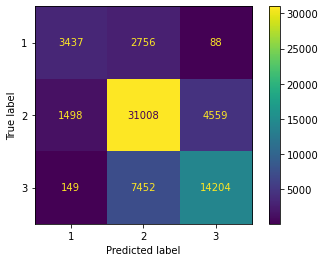

In [102]:
plot_confusion_matrix(target_tuned0, X_test, y_test);

In [103]:
cm = confusion_matrix(y_test, target_tuned0_preds)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 54.72% of low damage.
The model correctly predicts 83.66% of medium damage.
The model correctly predicts 65.14% of complete destruction.


### Export the model

In [104]:
#with open ('../Models/target_tuned0.pickle', 'wb') as f:
#    pickle.dump(target_tuned0, f, pickle.HIGHEST_PROTOCOL)